# Stock Quant

Team:
- Constantinos Vogiatzis cvogiatz@iu.edu
- Shubham Saurabh ssaurab@iu.edu
- Seth Smithson sesmit@iu.edu


# Preliminary Analysis

## Package installs

In [1]:
!pip install -q pmdarima 
!pip install -q alpha-vantage

In [2]:
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from datetime import timedelta

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.metrics import smape
from pmdarima.utils import acf, pacf
from sklearn.metrics import mean_squared_error, confusion_matrix
import numpy as np
from tqdm.notebook import tqdm

import plotly.graph_objects as go

mpl.rc('lines', linewidth=0.5)
VANTAGE_KEY = 'MUQXX1BUB5ZP3ZIC'    # Costas' free key

## Get stock prices

In [3]:
stock_code = "AMZN"
date_range = 'full'     # 'full'/'compact' - 'full' gets the full stock history, 'compact'
                        # the last 100 trading days or so

def fetch_prices(stock_code, date_range='full'):
    ts = TimeSeries(key=VANTAGE_KEY,output_format='pandas', indexing_type='date')
    df_prices, meta_data = ts.get_daily_adjusted(stock_code,outputsize=date_range)
    df_prices.rename(columns={
        '1. open':'open',
        '2. high':'high',
        '3. low':'low',
        '4. close':'close',
        '5. adjusted close':'adj_close',
        '6. volume':'volume',
        '7. dividend amount':'dividend',
        '8. split coefficient':'split'
    }, inplace=True)

    # Adjust open, low, high the same way as adjusted close - all prices are now adjusted for splits
    split_ratio = df_prices['adj_close']/df_prices['close']
    df_prices['open'] = df_prices['open'] * split_ratio
    df_prices['high'] = df_prices['high'] * split_ratio
    df_prices['low'] = df_prices['low'] * split_ratio
    df_prices['close'] = df_prices['close'] * split_ratio
    
    return df_prices

df_prices = fetch_prices(stock_code)
df_main = df_prices.copy()

# Reset the index so it is now consecutive trading days since the start of the dataset
df_prices.reset_index(inplace=True)
# Sort from old to new data
df_prices.sort_index(ascending=False, inplace=True)


## Time Series Visualization

**Note: Sometimes google colab produces the same plots twice. Please ignore that. It will not impact the final UI.**

### OHLC plot

In [6]:
def plot_ohlc(df_prices,log_plot=False):
    fig = go.Figure(data=go.Ohlc(x=df_prices['date'],
                        open=df_prices['open'],
                        high=df_prices['high'],
                        low=df_prices['low'],
                        close=df_prices['close']))
    fig.update_layout(
        title= 'OHLC Plot for ' + stock_code,
        yaxis_title= stock_code + ' Stock (Adjusted for splits)',
        autosize=False,
        width=1024,
        height=600)
    fig.update_yaxes(type=("log" if log_plot else "linear"))
    fig.show()

plot_ohlc(df_prices,log_plot=False)

In [7]:
plot_ohlc(df_prices,log_plot=True)

### ACF, PACF plots

In [8]:
# yacf, ci_acf, qstat, pvals = 
def plot_cf(prices, cf_type='ACF', nlags=100):

    yacf, ci_acf = ( acf(prices, alpha=0.05, nlags = nlags) if cf_type.lower()=='acf' else
                    pacf(prices, alpha=0.05, nlags = nlags) )
    ci_upper = ci_acf[:,1] - yacf
    ci_lower = ci_acf[:,0] - yacf

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.arange(nlags), y=yacf, name=cf_type,
                        line_shape='linear'))

    fig.add_trace(go.Scatter(x=np.arange(nlags), y=ci_lower,
        fill=None,
        mode='lines',
        line_color='indigo',
        name="CI-lower"
        ))
    fig.add_trace(go.Scatter(
        x=np.arange(nlags), y=ci_upper,
        fill='tonexty',
        fillcolor='rgba(0, 0, 255, 0.1)',
        mode='lines', line_color='indigo', name="CI-upper"))

    fig.update_traces(hoverinfo='text+name')
    fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16),    
                    xaxis_title= 'Lag in trading days',
                    yaxis_title= cf_type,
                    title = cf_type,
        autosize=True,
        width=1024,
        height=600)

    fig.show()

plot_cf(df_prices['close'], cf_type='ACF', nlags=min(1000,df_prices.shape[0]))
plot_cf(df_prices['close'], cf_type='PACF', nlags=min(200,df_prices.shape[0]))

---

### Stock Price Comparison plot

This functionality will allow users to compare the prices of any two stocks by plottting both on the same graph.

In [9]:
def plot_two_stocks(stock1_df, stock2_df, q_plot, stock1_name='Stock 1', stock2_name='Stock 2'):
    if q_plot not in ['open', 'close', 'low', 'high']:
        raise ValueError("q_plot must be one of 'open', 'close', 'low', or 'high'")

    # Assuming the date column in the DataFrames is named 'date'
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=stock1_df['date'],
        y=stock1_df[q_plot],
        name=f'{stock1_name} {q_plot.capitalize()}',
        line=dict(width=2)
    ))

    fig.add_trace(go.Scatter(
        x=stock2_df['date'],
        y=stock2_df[q_plot],
        name=f'{stock2_name} {q_plot.capitalize()}',
        line=dict(width=2)
    ))

    fig.update_layout(
        title=f"{q_plot.capitalize()} Prices for {stock1_name} and {stock2_name}",
        xaxis_title="Date",
        yaxis_title=f"{q_plot.capitalize()} Price"
    )

    fig.show()

stock_code_other = "AAPL"
df_prices_other = fetch_prices(stock_code_other)
df_prices_other.reset_index(inplace=True)
df_prices_other.sort_index(ascending=False, inplace=True)

plot_two_stocks(df_prices,df_prices_other,'close',stock_code,stock_code_other)

## Time Series Decomposition

### Decomposition using Prophet model

In [10]:
!pip install -q prophet

In [11]:
from prophet import Prophet

df_decompose = df_main[['adj_close']]
df_decompose = df_decompose.reset_index()
df_decompose.columns = ['ds', 'y']

# define the model
model = Prophet()

# fit the model
model.fit(df_decompose)

future = model.make_future_dataframe(periods=1)
forecast = model.predict(future)

17:05:11 - cmdstanpy - INFO - Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] done processing


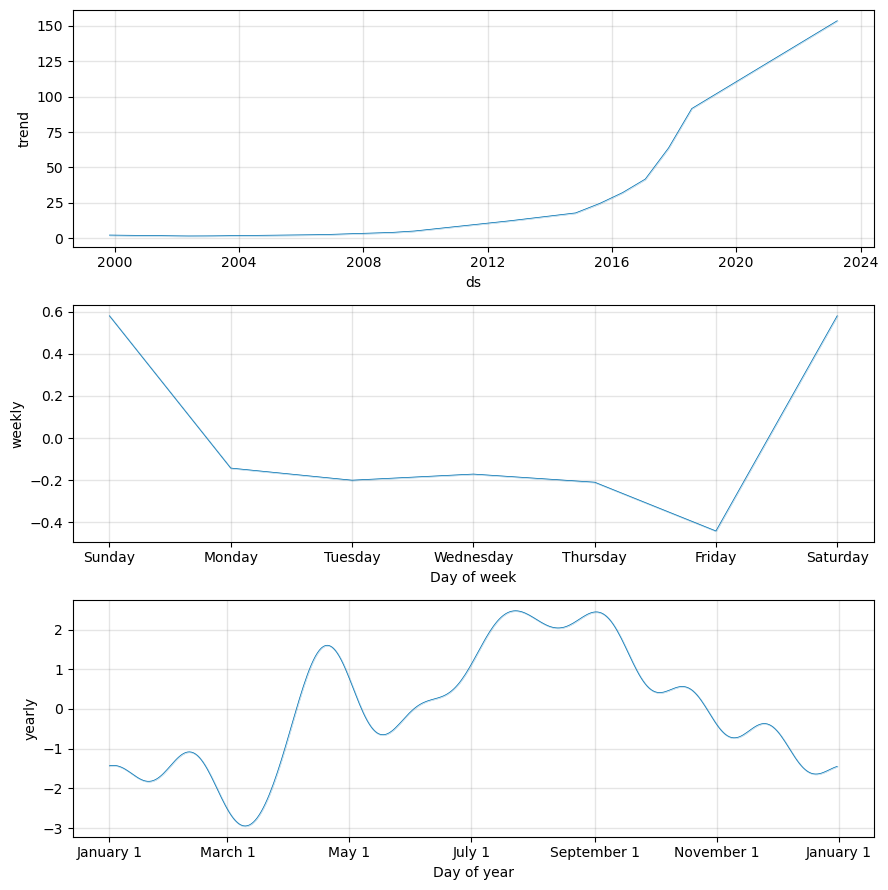

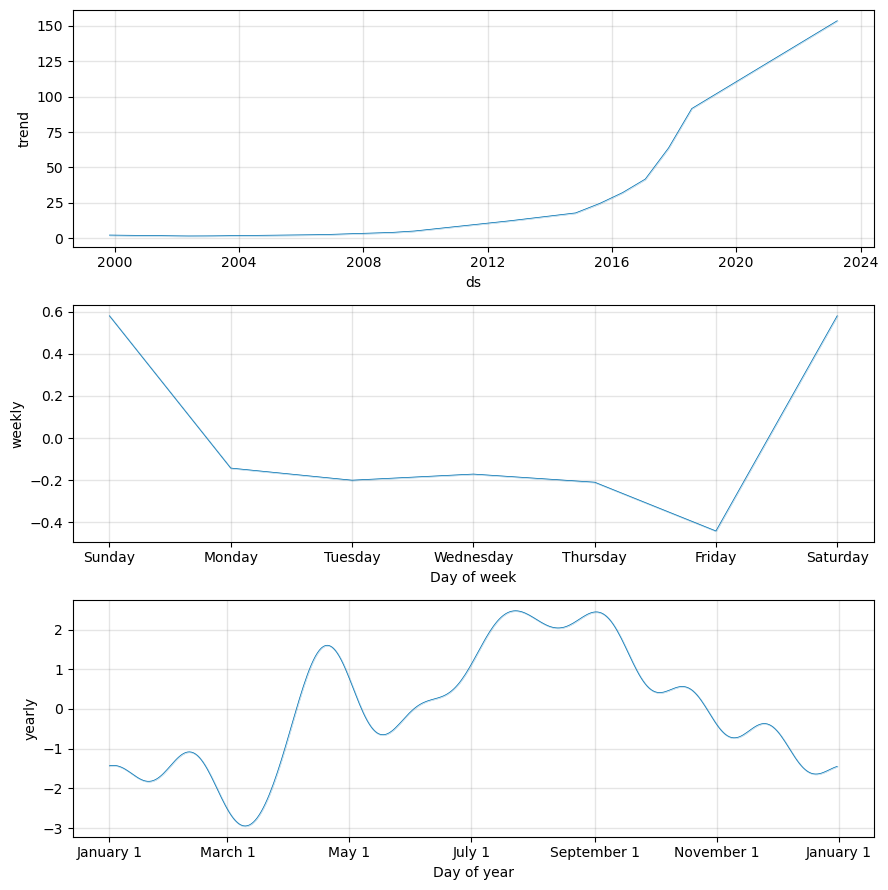

In [12]:
# Plot Components
model.plot_components(forecast)

### Decomposition using statsmodels.tsa

<AxesSubplot: title={'center': 'Annual Trend'}, xlabel='date'>

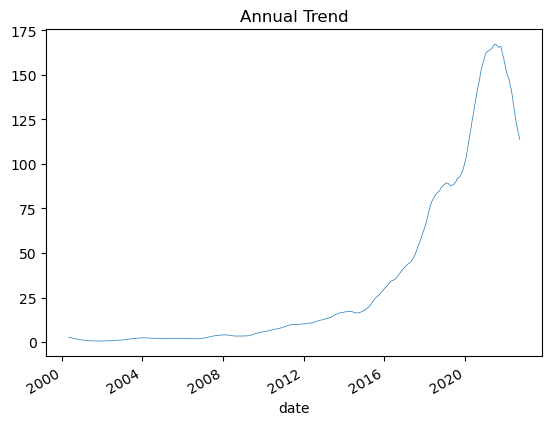

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_main['adj_close'], model='multiplicable', period=260) # assuming 260 business days in a year

decompose.trend.plot(title='Annual Trend')

<AxesSubplot: title={'center': 'Annual Seasonality'}, xlabel='date'>

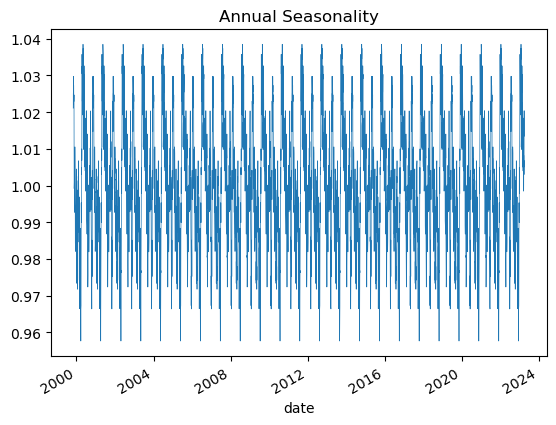

In [14]:
decompose.seasonal.plot(title='Annual Seasonality')

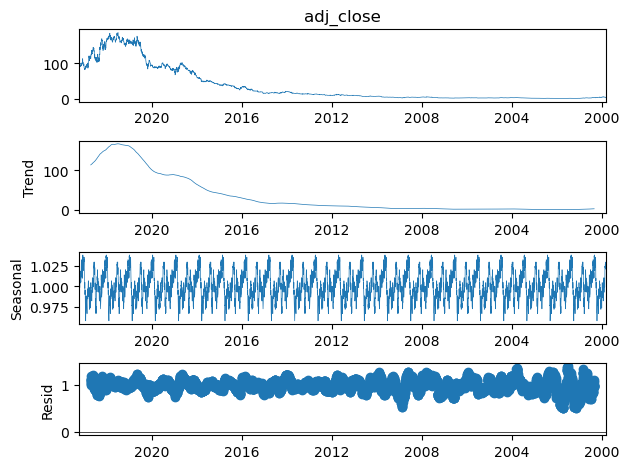

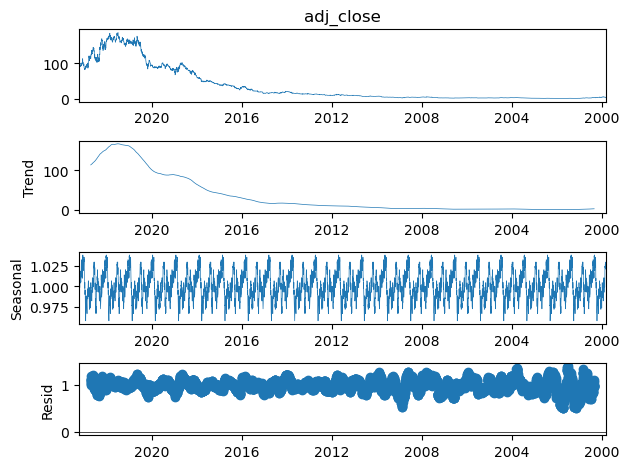

In [15]:
# Time Series Decomposition of stock_code (daily adjusted close values)
decompose.plot()

## Description of Time series

As expected from any stock price, there is a long term trend that corresponds to a general growth in the stock market. This will be true for any stock in general. 

Stock prices are non-stationary and do not exhibit seasonality. As seen in our plots above, there are no seasonality patterns on weekly, monthly or annual basis. The weekly seasonality observed in prophet forecast showing a high on the weekends should be ignored because the stock price data is available only for business days (not weekends). Hence, the seasonal decomposition does not provide any meaningful insights.

# Forecasting based on Quarterly Financial Data

Seth

Use data only till Sep-30-2022 to forecast for stock price on Dec-30-2022.


### Install Packages

In [13]:
# Alpha Vantage API
!pip install -q alpha-vantage

# Yahoo! Finance APOI
!pip install -q yfinance

# SciKit Optimizer
# !pip install scikit-optimize

# Install Tensorflow and Keras
# !pip install tensorflow keras

# Keras Tuner
!pip install -q keras-tuner

# SciKeras --> to use Keras/TensorFlow with sklearn
# !pip install scikeras[tensorflow]

# Bayesian Optimizer
# !pip install pip install bayesian-optimization

Load Packages

In [14]:
# Now, Let's import relevant python libraries

## Data Processing Libraries!
import numpy as np
import pandas as pd

# Importing pprint for better print displays of hyperparameters
from pprint import pprint

# Additional Imports
import requests
from datetime import datetime, timedelta
import json
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Import Alpha Vantage
from alpha_vantage.timeseries import TimeSeries

# Import Yahoo Finance
import yfinance as yf

# SciKitLearn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

# TensorFlow and Keras 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization


<ipython-input-14-5fdc1bf011af>:37: DeprecationWarning:

`import kerastuner` is deprecated, please use `import keras_tuner`.



### Data Preparation

---

Setup the API variables and desired Stock Ticker

---

In [15]:
# Define API variables
api_key = "KBBHKE0UHFRYF83S" # Seth's key
base_url = "https://www.alphavantage.co/query"

# Prompt User for a Ticker
ticker = stock_code

---

#### Pull some KPIs from the Income Statement via Alpha Vantage API

---

In [16]:
# Set the function parameters for the "Income Statement" endpoint of the Alpha Vantage API request
income_statement_params = {
    "function": "INCOME_STATEMENT",
    "symbol": ticker,
    "apikey": api_key,
    "period": "quarterly"
}

# Make a GET request to the Alpha Vantage API with the function parameters
income_statement_response = requests.get(base_url, params=income_statement_params)

# Convert the response content to a data frame using pandas
income_statement_data = pd.DataFrame(income_statement_response.json()["quarterlyReports"])

In [17]:
# Extract the financial metrics from the data frame
comprehensive_income_net_of_tax = income_statement_data["comprehensiveIncomeNetOfTax"] # Amount after tax of increase (decrease) in equity from transactions and other events and circumstances from net income and other comprehensive income, attributable to parent entity. Excludes changes in equity resulting from investments by owners and distributions to owners.
cost_of_revenue = income_statement_data["costOfRevenue"] # The aggregate cost of goods produced and sold and services rendered during the reporting period. 
COGS = income_statement_data["costofGoodsAndServicesSold"] # The aggregate costs related to goods produced and sold and services rendered by an entity during the reporting period. This excludes costs incurred during the reporting period related to financial services rendered and other revenue generating activities. 
# depreciation_amortization = income_statement_data["decpreciationAndAmortization"] # The current period expense charged against earnings on long-lived, physical assets not used in production, and which are not intended for resale, to allocate or recognize the cost of such assets over their useful lives; or to record the reduction in book value of an intangible asset over the benefit period of such asset; or to reflect consumption during the period of an asset that is not used in production. 
depreciation = income_statement_data["depreciation"] # The amount of expense recognized in the current period that reflects the allocation of the cost of tangible assets over the assets' useful lives. Includes production and non-production related depreciation. 
ebit = income_statement_data["ebit"] # The portion of profit or loss for the period, before income taxes and interest expenses, which is attributable to the parent.
ebitda = income_statement_data["ebitda"] # The portion of profit or loss for the period, before income taxes, interest expenses and depreciation and amortization, which is attributable to the parent. 
gross_profit = income_statement_data["grossProfit"] # Aggregate revenue less cost of goods and services sold or operating expenses directly attributable to the revenue generation activity. 
income_before_tax = income_statement_data["incomeBeforeTax"] # The portion of profit or loss for the period, before income taxes, which is attributable to the parent.
income_tax_expense = income_statement_data["incomeTaxExpense"] # Amount of current income tax expense (benefit) and deferred income tax expense (benefit) pertaining to continuing operations. 
interest_and_debt_expense = income_statement_data["interestAndDebtExpense"] # Interest and debt related expenses associated with nonoperating financing activities of the entity.
interest_expense = income_statement_data["interestExpense"] # Amount of the cost of borrowed funds accounted for as interest expense.
interest_income = income_statement_data["interestIncome"] # The amount of interest income.
net_investment_income = income_statement_data["investmentIncomeNet"] # Amount after accretion (amortization) of discount (premium), and investment expense, of interest income and dividend income on nonoperating securities.
net_income = income_statement_data["netIncome"] # The portion of profit or loss for the period, net of income taxes, which is attributable to the parent.
net_income_from_Ops = income_statement_data["netIncomeFromContinuingOperations"] # Amount after tax of income (loss) from continuing operations attributable to the parent.
net_interest_income = income_statement_data["netInterestIncome"] # The net amount of operating interest income (expense).
non_interest_income = income_statement_data["nonInterestIncome"] # The total amount of noninterest income which may be derived from: (1) fees and commissions; (2) premiums earned; (3) insurance policy charges; (4) the sale or disposal of assets; and (5) other sources not otherwise specified.
operating_expenses = income_statement_data["operatingExpenses"] # Generally recurring costs associated with normal operations except for the portion of these expenses which can be clearly related to production and included in cost of sales or services. Includes selling, general and administrative expense.
operating_income = income_statement_data["operatingIncome"] # The net result for the period of deducting operating expenses from operating revenues.
other_non_operating_income = income_statement_data["otherNonOperatingIncome"] # Amount of income (expense) related to nonoperating activities, classified as other.
RnD = income_statement_data["researchAndDevelopment"] # The aggregate costs incurred (1) in a planned search or critical investigation aimed at discovery of new knowledge with the hope that such knowledge will be useful in developing a new product or service, a new process or technique, or in bringing about a significant improvement to an existing product or process; or (2) to translate research findings or other knowledge into a plan or design for a new product or process or for a significant improvement to an existing product or process whether intended for sale or the entity's use, during the reporting period charged to research and development projects, including the costs of developing computer software up to the point in time of achieving technological feasibility, and costs allocated in accounting for a business combination to in-process projects deemed to have no alternative future use.
COS = income_statement_data["sellingGeneralAndAdministrative"] # The aggregate total costs related to selling a firm's product and services, as well as all other general and administrative expenses. Direct selling expenses (for example, credit, warranty, and advertising) are expenses that can be directly linked to the sale of specific products. Indirect selling expenses are expenses that cannot be directly linked to the sale of specific products, for example telephone expenses, Internet, and postal charges. General and administrative expenses include salaries of non-sales personnel, rent, utilities, communication, etc.
revenue = income_statement_data["totalRevenue"] # Amount of revenue recognized from goods sold, services rendered, insurance premiums, or other activities that constitute an earning process. Includes, but is not limited to, investment and interest income before deduction of interest expense when recognized as a component of revenue, and sales and trading gain (loss).

---

#### Pull some KPIs from the Cash Flow Statement via Alpha Vantage API

---

In [18]:
# Set the function parameters for the "Cash Flow" endpoint of the Alpha Vantage API request
cash_flow_params = {
    "function": "CASH_FLOW",
    "symbol": ticker,
    "apikey": api_key,
    "period": "quarter"
}

# Make a GET request to the Alpha Vantage API with the function parameters
cash_flow_response = requests.get(base_url, params=cash_flow_params)

# Convert the response content to a data frame using pandas
cash_flow_data = pd.DataFrame(cash_flow_response.json()["quarterlyReports"])

In [19]:
# Extract the financial metrics from the data frame
cap_ex = cash_flow_data["capitalExpenditures"] # The cash outflow for purchases of and capital improvements on property, plant and equipment (capital expenditures), software, and other intangible assets.
# cash_and_cash_equivalents_at_carrying_value = cash_flow_data["cashAndCashEquivalentsAtCarryingValue"] # Amount of currency on hand as well as demand deposits with banks or financial institutions. Includes other kinds of accounts that have the general characteristics of demand deposits. Also includes short-term, highly liquid investments that are both readily convertible to known amounts of cash and so near their maturity that they present insignificant risk of changes in value because of changes in interest rates. Excludes cash and cash equivalents within disposal group and discontinued operation.
cash_flow_from_financing = cash_flow_data["cashflowFromFinancing"] # Amount of cash inflow (outflow) from financing activities, including discontinued operations. Financing activity cash flows include obtaining resources from owners and providing them with a return on, and a return of, their investment; borrowing money and repaying amounts borrowed, or settling the obligation; and obtaining and paying for other resources obtained from creditors on long-term credit.
cash_flow_from_investment = cash_flow_data["cashflowFromInvestment"] # Amount of cash inflow (outflow) from investing activities, including discontinued operations. Investing activity cash flows include making and collecting loans and acquiring and disposing of debt or equity instruments and property, plant, and equipment and other productive assets.
change_in_cash_and_cash_equivalents = cash_flow_data["changeInCashAndCashEquivalents"] # Amount of increase (decrease) in cash and cash equivalents. Cash and cash equivalents are the amount of currency on hand as well as demand deposits with banks or financial institutions. Includes other kinds of accounts that have the general characteristics of demand deposits. Also includes short-term, highly liquid investments that are both readily convertible to known amounts of cash and so near their maturity that they present insignificant risk of changes in value because of changes in interest rates. Includes effect from exchange rate changes.
change_in_exchange_rate = cash_flow_data["changeInExchangeRate"] # Amount of increase (decrease) from the effect of exchange rate changes on cash and cash equivalent balances held in foreign currencies.
change_in_inventory = cash_flow_data["changeInInventory"] # The increase (decrease) during the reporting period in the aggregate value of all inventory held by the reporting entity, associated with underlying transactions that are classified as operating activities.
change_in_Op_Ex = cash_flow_data["changeInOperatingAssets"] # The increase (decrease) during the reporting period in the aggregate amount of assets used to generate operating income.
change_in_Op_liabilities = cash_flow_data["changeInOperatingLiabilities"] # The increase (decrease) during the reporting period in the aggregate amount of liabilities that result from activities that generate operating income.
change_in_receivables = cash_flow_data["changeInReceivables"] # The increase (decrease) during the reporting period in the total amount due within one year (or one operating cycle) from all parties, associated with underlying transactions that are classified as operating activities.
depreciation_depletion_amortization = cash_flow_data["depreciationDepletionAndAmortization"] # The aggregate expense recognized in the current period that allocates the cost of tangible assets, intangible assets, or depleting assets to periods that benefit from use of the assets.
dividend_payout_total = cash_flow_data["dividendPayout"] # Cash outflow in the form of capital distributions and dividends to common shareholders, preferred shareholders and noncontrolling interests.
dividend_payout_common_stock = cash_flow_data["dividendPayoutCommonStock"] # Amount of cash outflow in the form of ordinary dividends to common shareholders of the parent entity.
dividend_payout_preferred_stock = cash_flow_data["dividendPayoutPreferredStock"] # Amount of cash outflow in the form of ordinary dividends to preferred shareholders of the parent entity.
net_income = cash_flow_data["netIncome"] # The portion of profit or loss for the period, net of income taxes, which is attributable to the parent.
operating_cashflow = cash_flow_data["operatingCashflow"] # A useful metric from the Cash Flow Statement.  Amount of cash inflow (outflow) from operating activities, including discontinued operations. Operating activity cash flows include transactions, adjustments, and changes in value not defined as investing or financing activities.
payments_for_Op_activities = cash_flow_data["paymentsForOperatingActivities"] # Total amount of cash paid for operating activities during the current period.
stock_buybacks_common = cash_flow_data["paymentsForRepurchaseOfCommonStock"] # The cash outflow to reacquire common stock during the period.
stock_buybacks_all = cash_flow_data["paymentsForRepurchaseOfEquity"] # The cash outflow to reacquire common and preferred stock.
stock_buybacks_preferred = cash_flow_data["paymentsForRepurchaseOfPreferredStock"] # The cash outflow to reacquire preferred stock during the period.
stock_issuance = cash_flow_data["proceedsFromIssuanceOfCommonStock"] # The cash inflow from the additional capital contribution to the entity.
cash_raised_from_debt_and_equity = cash_flow_data["proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet"] # The cash inflow associated with security instrument that either represents a creditor or an ownership relationship with the holder of the investment security with a maturity of beyond one year or normal operating cycle, if longer. Includes proceeds from (a) debt, (b) capital lease obligations, (c) mandatory redeemable capital securities, and (d) any combination of (a), (b), or (c). 
cash_raised_preferred_stock = cash_flow_data["proceedsFromIssuanceOfPreferredStock"] # Proceeds from issuance of capital stock which provides for a specific dividend that is paid to the shareholders before any dividends to common stockholder, which takes precedence over common stockholders in the event of liquidation and from issuance of rights to purchase common shares at a predetermined price.
cash_raised_Op_activities = cash_flow_data["proceedsFromOperatingActivities"] # Total amount of cash received from operating activities during the current period.
cash_raised_from_short_term_debt = cash_flow_data["proceedsFromRepaymentsOfShortTermDebt"] # The net cash inflow or outflow for borrowing having initial term of repayment within one year or the normal operating cycle, if longer.
net_cash_from_equity = cash_flow_data["proceedsFromRepurchaseOfEquity"] # The net cash inflow or outflow resulting from the entity's share transaction.
cash_raised_treasury_stock = cash_flow_data["proceedsFromSaleOfTreasuryStock"] # The cash inflow from the issuance of an equity stock that has been previously reacquired by the entity.
profit_loss = cash_flow_data["profitLoss"] # The consolidated profit or loss for the period, net of income taxes, including the portion attributable to the noncontrolling interest.

---

#### Pull some KPIs from the Balance Sheet via Alpha Vantage API

---

In [20]:
# Set the function parameters for the "Balance Sheet" endpoint of the Alpha Vantage API request
balance_sheet_params = {
    "function": "BALANCE_SHEET",
    "symbol": ticker,
    "apikey": api_key,
    "period": "quarter"
}

# Make a GET request to the Alpha Vantage API with the function parameters
balance_sheet_response = requests.get(base_url, params=balance_sheet_params)

# Convert the response content to a data frame using pandas
balance_sheet_data = pd.DataFrame(balance_sheet_response.json()["quarterlyReports"])

In [21]:
# Extract the financial metrics from the data frame
accumulated_depreciation_ammortization_PPE = balance_sheet_data["accumulatedDepreciationAmortizationPPE"] # Amount of accumulated depreciation, depletion and amortization for physical assets used in the normal conduct of business to produce goods and services.
capital_lease_obligations = balance_sheet_data["capitalLeaseObligations"] # Present value of lessee's discounted obligation for lease payments from finance lease, classified as noncurrent.
cash_and_cash_equivalents_at_carrying_value = balance_sheet_data["cashAndCashEquivalentsAtCarryingValue"] # Amount of currency on hand as well as demand deposits with banks or financial institutions. Includes other kinds of accounts that have the general characteristics of demand deposits. Also includes short-term, highly liquid investments that are both readily convertible to known amounts of cash and so near their maturity that they present insignificant risk of changes in value because of changes in interest rates. Excludes cash and cash equivalents within disposal group and discontinued operation. 
cash_and_short_term_investments = balance_sheet_data["cashAndShortTermInvestments"] # Cash includes currency on hand as well as demand deposits with banks or financial institutions. It also includes other kinds of accounts that have the general characteristics of demand deposits in that the customer may deposit additional funds at any time and effectively may withdraw funds at any time without prior notice or penalty. Cash equivalents, excluding items classified as marketable securities, include short-term, highly liquid Investments that are both readily convertible to known amounts of cash, and so near their maturity that they present minimal risk of changes in value because of changes in interest rates. Generally, only investments with original maturities of three months or less qualify under that definition. Original maturity means original maturity to the entity holding the investment. For example, both a three-month US Treasury bill and a three-year Treasury note purchased three months from maturity qualify as cash equivalents. However, a Treasury note purchased three years ago does not become a cash equivalent when its remaining maturity is three months. Short-term investments, exclusive of cash equivalents, generally consist of marketable securities intended to be sold within one year (or the normal operating cycle if longer) and may include trading securities, available-for-sale securities, or held-to-maturity securities (if maturing within one year), as applicable.
common_stock = balance_sheet_data["commonStock"] # Aggregate par or stated value of issued nonredeemable common stock (or common stock redeemable solely at the option of the issuer). This item includes treasury stock repurchased by the entity. Note: elements for number of nonredeemable common shares, par value and other disclosure concepts are in another section within stockholders' equity.
outstanding_shares = balance_sheet_data["commonStockSharesOutstanding"] # Best estimate of Common Stock Shares Outstanding. If a company does not report a period end value the amount defaults to the reported value for the quarterly Weighted Average Shares Outstanding without dilution (us-gaap::WeightedAverageNumberOfSharesOutstandingBasic)
current_accounts_payable = balance_sheet_data["currentAccountsPayable"] # Carrying value as of the balance sheet date of liabilities incurred (and for which invoices have typically been received) and payable to vendors for goods and services received that are used in an entity's business. Used to reflect the current portion of the liabilities (due within one year or within the normal operating cycle if longer).
current_debt = balance_sheet_data["currentDebt"] # Amount of short-term debt and current maturity of long-term debt and capital lease obligations due within one year or the normal operating cycle, if longer.
current_long_term_debt = balance_sheet_data["currentLongTermDebt"] # Amount, after unamortized (discount) premium and debt issuance costs, of long-term debt, classified as current. Includes, but not limited to, notes payable, bonds payable, debentures, mortgage loans and commercial paper. Excludes capital lease obligations.
current_net_receivables = balance_sheet_data["currentNetReceivables"] # The total amount due to the entity within one year of the balance sheet date (or one operating cycle, if longer) from outside sources, including trade accounts receivable, notes and loans receivable, as well as any other types of receivables, net of allowances established for the purpose of reducing such receivables to an amount that approximates their net realizable value.
# long_term_short_term_debt = balance_sheet_data["debtLongtermAndShorttermCombinedAmount"] # Represents the aggregate of total long-term debt, including current maturities and short-term debt.
deferred_revenue = balance_sheet_data["deferredRevenue"] # Amount of deferred income and obligation to transfer product and service to customer for which consideration has been received or is receivable.
goodwill = balance_sheet_data["goodwill"] # Amount after accumulated impairment loss of an asset representing future economic benefits arising from other assets acquired in a business combination that are not individually identified and separately recognized. 
intangible_assets = balance_sheet_data["intangibleAssets"] # Carrying amount of finite-lived intangible assets, indefinite-lived intangible assets and goodwill. Goodwill is an asset representing the future economic benefits arising from other assets acquired in a business combination that are not individually identified and separately recognized. Intangible assets are assets, not including financial assets, lacking physical substance.
intangible_assets_excluding_goodwill = balance_sheet_data["intangibleAssetsExcludingGoodwill"] # Sum of the carrying amounts of all intangible assets, excluding goodwill, as of the balance sheet date, net of accumulated amortization and impairment charges.
inventory = balance_sheet_data["inventory"] # Amount after valuation and LIFO reserves of inventory expected to be sold, or consumed within one year or operating cycle, if longer.
investments = balance_sheet_data["investments"] # Sum of the carrying amounts as of the balance sheet date of all investments.
long_term_debt = balance_sheet_data["longTermDebt"] # Amount, after unamortized (discount) premium and debt issuance costs, of long-term debt. Includes, but not limited to, notes payable, bonds payable, debentures, mortgage loans and commercial paper. Excludes capital lease obligations.
long_term_debt_noncurrent = balance_sheet_data["longTermDebtNoncurrent"] # Amount after unamortized (discount) premium and debt issuance costs of long-term debt classified as noncurrent and excluding amounts to be repaid within one year or the normal operating cycle, if longer. Includes, but not limited to, notes payable, bonds payable, debentures, mortgage loans and commercial paper. Excludes capital lease obligations.
long_term_investments = balance_sheet_data["longTermInvestments"] # The total amount of investments that are intended to be held for an extended period of time (longer than one operating cycle).
other_current_assets = balance_sheet_data["otherCurrentAssets"] #  Amount of current assets classified as other.
other_current_liabilities = balance_sheet_data["otherCurrentLiabilities"] # Amount of liabilities classified as other, due within one year or the normal operating cycle, if longer.
other_noncurrent_liabilities = balance_sheet_data["otherNonCurrentLiabilities"] # Amount of liabilities classified as other, due after one year or the normal operating cycle, if longer.
# other_noncurrent_assets = balance_sheet_data["otherNonCurrrentAssets"] # Amount of noncurrent assets classified as other.
property_plant_equipment = balance_sheet_data["propertyPlantEquipment"] # Amount after accumulated depreciation, depletion and amortization of physical assets used in the normal conduct of business to produce goods and services and not intended for resale. Examples include, but are not limited to, land, buildings, machinery and equipment, office equipment, and furniture and fixtures.
retained_earnings = balance_sheet_data["retainedEarnings"] # The cumulative amount of the reporting entity's undistributed earnings or deficit.
short_term_debt = balance_sheet_data["shortTermDebt"] # Reflects the total carrying amount as of the balance sheet date of debt having initial terms less than one year or the normal operating cycle, if longer.
short_term_investments = balance_sheet_data["shortTermInvestments"] # Amount of investments including trading securities, available-for-sale securities, held-to-maturity securities, and short-term investments classified as other and current.
total_assets = balance_sheet_data["totalAssets"] # Sum of the carrying amounts as of the balance sheet date of all assets that are recognized. Assets are probable future economic benefits obtained or controlled by an entity as a result of past transactions or events.
current_assets = balance_sheet_data["totalCurrentAssets"] # Sum of the carrying amounts as of the balance sheet date of all assets that are expected to be realized in cash, sold, or consumed within one year (or the normal operating cycle, if longer). Assets are probable future economic benefits obtained or controlled by an entity as a result of past transactions or events.
current_liabilities = balance_sheet_data["totalCurrentLiabilities"] # Total obligations incurred as part of normal operations that are expected to be paid during the following twelve months or within one business cycle, if longer.
total_liabilities = balance_sheet_data["totalLiabilities"] # Sum of the carrying amounts as of the balance sheet date of all liabilities that are recognized. Liabilities are probable future sacrifices of economic benefits arising from present obligations of an entity to transfer assets or provide services to other entities in the future. 
total_noncurrent_assets = balance_sheet_data["totalNonCurrentAssets"] # Sum of the carrying amounts as of the balance sheet date of all assets that are expected to be realized in cash, sold or consumed after one year or beyond the normal operating cycle, if longer.
total_noncurrent_liabilities = balance_sheet_data["totalNonCurrentLiabilities"] # Amount of obligation due after one year or beyond the normal operating cycle, if longer.
shareholder_equity = balance_sheet_data["totalShareholderEquity"] # Target Variable! Total of all stockholders' equity (deficit) items, net of receivables from officers, directors, owners, and affiliates of the entity which are attributable to the parent. The amount of the economic entity's stockholders' equity attributable to the parent excludes the amount of stockholders' equity which is allocable to that ownership interest in subsidiary equity which is not attributable to the parent (noncontrolling interest, minority interest). This excludes temporary equity and is sometimes called permanent equity. 
treasury_stock = balance_sheet_data["treasuryStock"] # The amount allocated to treasury stock. Treasury stock is common and preferred shares of an entity that were issued, repurchased by the entity, and are held in its treasury.

---

#### Make the all-inclusive dataframe

---

In [22]:
# Create a data frame of the financial metrics
financial_metrics = pd.DataFrame({
    "Date": income_statement_data["fiscalDateEnding"],
    "Comprehensive_Income_Net_of_Tax": comprehensive_income_net_of_tax,
    "Cost_of_Revenue": cost_of_revenue,
    "COGS": COGS,
    "Depreciation": depreciation,
    "EBIT": ebit,
    "EBITDA": ebitda,
    "Gross_Profit": gross_profit,
    "Income_Before_Tax": income_before_tax,
    "Income_Tax_Expense": income_tax_expense,
    "Interest_and_Debt_Expense": interest_and_debt_expense,
    "Interest_Expense": interest_expense,
    "Interest_Income": interest_income,
    "Net_Investment_Income": net_investment_income,
    "Net_Income": net_income,
    "Net_Income_from_Ops": net_income_from_Ops,
    "Net_Interest_Income": net_interest_income,
    "Non_Interest_Income": non_interest_income,
    "Operating Expenses": operating_expenses,
    "Operating_Income": operating_income,
    "Other_Non_Operating_Income": other_non_operating_income,
    "RnD": RnD,
    "COS": COS,
    "Revenue": revenue,
    "Cap_Ex": cap_ex,
    "Cash_Flow_from_Financing": cash_flow_from_financing,
    "Cash_Flow_from_Investment": cash_flow_from_investment,
    "Change_in_Cash_and_Cash_Equivalents": change_in_cash_and_cash_equivalents,
    "Change_in_Exchange_Rate": change_in_exchange_rate,
    "Change_in_Inventory": change_in_inventory,
    "Change_in_Op_Ex": change_in_Op_Ex,
    "Change_in_Op_Liabilities": change_in_Op_liabilities,
    "Change_in_Receivables": change_in_receivables,
    "Depreciation_Depletion_Amortization": depreciation_depletion_amortization,
    "Dividend_Payout_Total": dividend_payout_total,
    "Dividend_Payout_Common_Stock": dividend_payout_common_stock,
    "Dividend_Payout_Preferred_Stock": dividend_payout_preferred_stock,
    "Net_Income": net_income,
    "Operating_Cashflow": operating_cashflow,
    "Payments_for_Op_Activities": payments_for_Op_activities,
    "Stock_Buybacks_Common": stock_buybacks_common,
    "Stock_Buybacks_All": stock_buybacks_all,
    "Stock_Buybacks_Preferred": stock_buybacks_preferred,
    "Stock_Issuance": stock_issuance,
    "Cash_Raised_from_Debt_and_Equity": cash_raised_from_debt_and_equity,
    "Cash_Raised_Preferred_Stock": cash_raised_preferred_stock,
    "Cash_Raised_Op_Activities": cash_raised_Op_activities,
    "Cash_Raised_from_Short_Term_Debt": cash_raised_from_short_term_debt,
    "Net_Cash_from_Equity": net_cash_from_equity,
    "Cash_Raised_Treasury_Stock": cash_raised_treasury_stock,
    "Profit_Loss": profit_loss,
    "Accumulated_Depreciation_Ammortization_PPE": accumulated_depreciation_ammortization_PPE,
    "Capital_Lease_Obligations": capital_lease_obligations,
    "Cash_and_Cash_Equivalents_at_Carrying_Value": cash_and_cash_equivalents_at_carrying_value,
    "Cash_and_Short_Term_Investments": cash_and_short_term_investments,
    "Common_Stock": common_stock,
    "Outstanding_Shares": outstanding_shares,
    "Current_AP": current_accounts_payable,
    "Current_Debt": current_debt,
    "Current_Long_Term_Debt": current_long_term_debt,
    "Current_net_receivables": current_net_receivables,
    "Deferred_Revenue": deferred_revenue,
    "Goodwill": goodwill,
    "Intangible_Assets": intangible_assets,
    "Intangible_Assets_Excluding_Goodwill": intangible_assets_excluding_goodwill,
    "Inventory": inventory,
    "Investments": investments,
    "Long_Term_Debt": long_term_debt,
    "Long_Term_Debt_Noncurrent": long_term_debt_noncurrent,
    "Long_Term_Investments": long_term_investments,
    "Other_Current_Assets": other_current_assets,
    "Other_Current_Liabilities": other_current_liabilities,
    "Other_Noncurrent_Liabilities": other_noncurrent_liabilities,
    "Property_Plant_Equipment": property_plant_equipment,
    "Retained_Earnings": retained_earnings,
    "Short_Term_Debt": short_term_debt,
    "Short_Term_Investments": short_term_investments,
    "Total_Assets": total_assets,
    "Current_Assets": current_assets,
    "Current_Liabilities": current_liabilities,
    "Total_Liabilities": total_liabilities,
    "Total_Noncurrent_Assets": total_noncurrent_assets,
    "Total_Noncurrent_Liabilities": total_noncurrent_liabilities,
    "Shareholder_Equity": shareholder_equity, # Target Variable, also known as Market Capitalization
    "Treasury_Stock": treasury_stock
})

In [23]:
# Print the financial metrics data frame
print(financial_metrics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 84 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Date                                         20 non-null     object
 1   Comprehensive_Income_Net_of_Tax              20 non-null     object
 2   Cost_of_Revenue                              20 non-null     object
 3   COGS                                         20 non-null     object
 4   Depreciation                                 20 non-null     object
 5   EBIT                                         20 non-null     object
 6   EBITDA                                       20 non-null     object
 7   Gross_Profit                                 20 non-null     object
 8   Income_Before_Tax                            20 non-null     object
 9   Income_Tax_Expense                           20 non-null     object
 10  Interest_and_Deb

*The data type of all these variables is 'object' - which needs to be converted into numeric format for further processing.*

In [24]:
# Convert Any occurence of "None" to 0.  This will stave off later errors occurring in converting.
financial_metrics = financial_metrics.replace("None", 0)

# Date Column
financial_metrics.Date = pd.to_datetime(financial_metrics.Date) # ISO Formant

# Columns with Numbers;
financial_metrics.loc[:, financial_metrics.columns != "Date"] = financial_metrics.loc[:, financial_metrics.columns != "Date"].astype('int64')

# Check!
print(financial_metrics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 84 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Date                                         20 non-null     datetime64[ns]
 1   Comprehensive_Income_Net_of_Tax              20 non-null     int64         
 2   Cost_of_Revenue                              20 non-null     int64         
 3   COGS                                         20 non-null     int64         
 4   Depreciation                                 20 non-null     int64         
 5   EBIT                                         20 non-null     int64         
 6   EBITDA                                       20 non-null     int64         
 7   Gross_Profit                                 20 non-null     int64         
 8   Income_Before_Tax                            20 non-null     int64         
 9   I

---

#### Feature Engineering

---

In [25]:
# Convert Any occurence of "None" to 0.  This will stave off later errors occurring in converting.
financial_metrics = financial_metrics.replace("None", 0)

# Format the Date Column
financial_metrics.Date = pd.to_datetime(financial_metrics.Date, format='%Y-%m-%d') # ISO Format

# Convert the numbers
financial_metrics.loc[:, financial_metrics.columns != "Date"] = financial_metrics.loc[:, financial_metrics.columns != "Date"].astype('int64')

#### Add Several Financial Metrics

# Gross Profit Margin
# Gross Profit Margin = (Revenue - Cost of Sales) / Revenue * 100
# This measures the percentage of revenue after subtracting the cost of goods sold (does not include overhead -- operating expenses, interest, or taxes)
financial_metrics["Gross_Profit_Margin"] = ((financial_metrics.Revenue - financial_metrics.COGS) / financial_metrics.Revenue)

# Net Profit Margin
# Net Profit Margin = Net Profit / Revenue * 100
# This measures the percentage of revenue and other incomei s left after subtracting all costs for the business, including COGs and overhead (OpEx, Interest, and Taxes)
financial_metrics["Net_Profit_Margin"] = ((financial_metrics.Profit_Loss / financial_metrics.Revenue) * 100)

# Working Capital
# Working Capital = Current Assets - Current Liabilities
# This measures the business’s available operating liquidity, which can be used to fund day-to-day operations.
financial_metrics["Working_Capital"] = (financial_metrics.Current_Assets - financial_metrics.Current_Liabilities)

# Current Ratio
# Current Ratio = Current Assets / Current Liabilities
# This is a liquidity ratio that helps understand whether the business can pay its short-term obligations—that is (liabilities due at or within 1 yr).
financial_metrics["Current_Ratio"] = financial_metrics.Current_Assets / financial_metrics.Current_Liabilities

# Quick Ratio (Acid Test Ratio)
# Quick Ratio = (Current Assets - Inventory) / Current Liabilities
# liquidity ratio that measures a business’s ability to handle short-term obligations. The quick ratio uses only highly liquid current assets, such as cash, marketable securities, and accounts receivables, in its numerator. The assumption is that certain current assets, like inventory, are not necessarily easy to turn into cash.
financial_metrics["Quick_Ratio"] = ((financial_metrics.Current_Assets - financial_metrics.Inventory) / financial_metrics.Current_Liabilities)

# Leverage Ratio ("Equity Multiplier")
# Leverage = Total Assets / Total Equity
# refers to the use of debt to buy assets. If all the assets are financed by equity, the multiplier is one. As debt increases, the multiplier increases from one, demonstrating the leverage impact of the debt and, ultimately, increasing the risk of the business.
financial_metrics["Leverage_Ratio"] = financial_metrics.Total_Assets / financial_metrics.Shareholder_Equity

# Debt-to-Equity Ratio
# Debt to Equity Ratio = Total Debt / Total Equity
# solvency ratio that measures how much a company finances itself using equity versus debt. This ratio provides insight into the solvency of the business by reflecting the ability of shareholder equity to cover all debt in the event of a business downturn.
financial_metrics["Debt-to-Equity_Ratio"] = ((financial_metrics.Long_Term_Debt + financial_metrics.Short_Term_Debt) / financial_metrics.Shareholder_Equity)

# Earning per Share
# ROA = Net Profit / (Beginning Total Assets + Ending Total Assets) / 2
# another profitability ratio, similar to ROE, which is measured by dividing net profit by the company’s average assets. It’s an indicator of how well the company is managing its available resources and assets to net higher profits.
financial_metrics["EPS"] = (financial_metrics.Revenue / financial_metrics.Outstanding_Shares)

# These calculations product some columns with float64 values.  While they are decimals, they do not need to be as long as float64.  This creates problems later.
financial_metrics.Gross_Profit_Margin = financial_metrics.Gross_Profit_Margin.astype("float16")
financial_metrics.Net_Profit_Margin = financial_metrics.Net_Profit_Margin.astype("float16")
financial_metrics.Current_Ratio = financial_metrics.Current_Ratio.astype("float16")
financial_metrics.Quick_Ratio = financial_metrics.Quick_Ratio.astype("float16")
financial_metrics.Leverage_Ratio = financial_metrics.Leverage_Ratio.astype("float16")
financial_metrics["Debt-to-Equity_Ratio"] = financial_metrics["Debt-to-Equity_Ratio"].astype("float16")
financial_metrics["EPS"] = financial_metrics["EPS"].astype("float16")

In [26]:
# Check!
print(financial_metrics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 92 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Date                                         20 non-null     datetime64[ns]
 1   Comprehensive_Income_Net_of_Tax              20 non-null     int64         
 2   Cost_of_Revenue                              20 non-null     int64         
 3   COGS                                         20 non-null     int64         
 4   Depreciation                                 20 non-null     int64         
 5   EBIT                                         20 non-null     int64         
 6   EBITDA                                       20 non-null     int64         
 7   Gross_Profit                                 20 non-null     int64         
 8   Income_Before_Tax                            20 non-null     int64         
 9   I

---

#### Data Cleaning

---

In [27]:
# Are there any null values in the dataframe?
financial_metrics.isnull().values.any()

False

In [28]:
# Add up how many Null values there are
financial_metrics.isnull().sum().sum()

0

In [29]:
# Check for any infinite values
financial_metrics.isin([np.inf, -np.inf]).any().any()

False

In [30]:
# Print out the whole dataframe to look for infinitie or NAN values
# print(financial_metrics.to_markdown()) # uncomment if any of the above is true

---

#### Add the Target Variable (Stock Price)

---

With Alpha Vantage API, it is possible to pull the stock price on a daily, weekly, and monthly basis.  However, these financial statements are only posted on a Quarterly basis.  Therefore, deriving the stock price means pulling it from the dates the reports are filed and adding it to the report.  Unfortunately, this is a premium feature in Alpha Vantage API, so we are going to use yfinance to download that data and add it to the dataframe.

In [31]:
# Note there may be a cap on how many requests the Yahoo Finance API may fill.
# If there are too many requests, the following error may be displayed.

In [32]:
# Assign the Variable
symbol = ticker

# Sample DataFrame with dates
data = {'Date': financial_metrics.Date.tolist()}
df = pd.DataFrame(data)

# Download historical closing prices for the stock
start_date = df['Date'].min()
end_date = df['Date'].max()
stock_data = yf.download(symbol, start=start_date, end=end_date)
stock_data = stock_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [33]:
# Add stock prices to the DataFrame based on the column of dates
def get_closing_price(date, stock_data):
    try:
        return stock_data.loc[date, 'Close']
    except KeyError:
        print(f'Error: No data found for {symbol} on {date}. Searching for the closest business day.')
        closest_date = stock_data.index.get_loc(date, method='nearest')
        return stock_data.iloc[closest_date]['Close']

In [34]:
# Create a Dataframe from the pulled data
df['Date'] = pd.to_datetime(df['Date'])

In [35]:
# Set the index to the date to make merging dataframes easier
df.set_index('Date', inplace=True)

In [36]:
# Add the Closing Price data
df['Closing_Price'] = df.index.to_series().apply(get_closing_price, args=(stock_data,))

Error: No data found for AMZN on 2022-12-31 00:00:00. Searching for the closest business day.
Error: No data found for AMZN on 2019-06-30 00:00:00. Searching for the closest business day.
Error: No data found for AMZN on 2019-03-31 00:00:00. Searching for the closest business day.
Error: No data found for AMZN on 2018-09-30 00:00:00. Searching for the closest business day.
Error: No data found for AMZN on 2018-06-30 00:00:00. Searching for the closest business day.
Error: No data found for AMZN on 2018-03-31 00:00:00. Searching for the closest business day.


<ipython-input-33-5c18c6a2391e>:7: FutureWarning:

Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.



In [37]:
# Check if the function worked
print(df)

            Closing_Price
Date                     
2022-12-31      84.000000
2022-09-30     113.000000
2022-06-30     106.209999
2022-03-31     162.997498
2021-12-31     166.716995
2021-09-30     164.251999
2021-06-30     172.007996
2021-03-31     154.703995
2020-12-31     162.846497
2020-09-30     157.436493
2020-06-30     137.940994
2020-03-31      97.486000
2019-12-31      92.391998
2019-09-30      86.795502
2019-06-30      96.109497
2019-03-31      90.709503
2018-12-31      75.098503
2018-09-30     100.218002
2018-06-30      84.989998
2018-03-31      68.599503


In [38]:
# Set the Date Column as the Index for the financial_metrics dataframe
financial_metrics.set_index("Date", inplace=True)

# Merge the stock price DataFrame with the Financial Statements DataFrame
financial_metrics = financial_metrics.join(df, how="inner")

# Check the DF
print(financial_metrics.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2022-12-31 to 2018-03-31
Data columns (total 92 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Comprehensive_Income_Net_of_Tax              20 non-null     int64  
 1   Cost_of_Revenue                              20 non-null     int64  
 2   COGS                                         20 non-null     int64  
 3   Depreciation                                 20 non-null     int64  
 4   EBIT                                         20 non-null     int64  
 5   EBITDA                                       20 non-null     int64  
 6   Gross_Profit                                 20 non-null     int64  
 7   Income_Before_Tax                            20 non-null     int64  
 8   Income_Tax_Expense                           20 non-null     int64  
 9   Interest_and_Debt_Expense                    20 non-null  

In [39]:
# Print out the whole dataframe to look for infinitie or NAN values
# print(financial_metrics.to_markdown()) # uncomment if need to investigate

---

#### Remove the target row

---

In [40]:
# Preserve the row to predict
latest_quater_df = financial_metrics.iloc[[0]]

# Remove the first row from the original DataFrame
financial_metrics = financial_metrics.iloc[1:]

# Select the relevant data to calculate the stock price
target_stock_price = latest_quater_df.Closing_Price

# Print the Target Stock Price
print(target_stock_price)

Date
2022-12-31    84.0
Name: Closing_Price, dtype: float64


---

### LSTM modeling

---

---

Setup the GPU

---

In [41]:
# Setup the GPU (Google Colab)
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
  raise SystemError("GPU device not found")
print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


---

Clear directores if re-running the model

---

In [42]:
# Run only when getting a tuner file error

# Import
import shutil

# Define variables
tuner_directory = "my_dir"
project_name = "multivariate_timeseries"

# Remove the previous tuner directory if it exists
shutil.rmtree(f"{tuner_directory}/{project_name}", ignore_errors=True)

---

#### Load, Scale, and Assign the Data

---

In [43]:
# 1. Load the dataset
data = financial_metrics

In [44]:
# 2. Set the target variable
target_var = 'Closing_Price'

In [45]:
# 3. Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [46]:
# 4. Split the dataset into train and test sets (use all data for training in this case)
X_train, y_train = scaled_data[:, 1:], scaled_data[:, 0]

---

#### Define the Model and Hyperparameter Tuner

---

In [47]:
# 5. Use Bayesian optimization for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [48]:
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=25,
    executions_per_trial=5,
    directory='bayesian_optimization',
    project_name='stock_price_prediction'
)

---

#### Stop.  It's Model Time.

---

In [49]:
# Display the Tuner Search Space Summary
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [50]:
# 6. Train the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [51]:
# Search!
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Trial 25 Complete [00h 02m 53s]
val_loss: 0.0004355630953796208

Best val_loss So Far: 0.0003295243484899402
Total elapsed time: 01h 03m 52s


In [52]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [53]:
# Display the Best Hyperparameters determined:
print(f"Best hyperparameters: {best_hps}")

Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f8ea01d6a30>


In [54]:
# Define the model with the bet hyperparameters
model = tuner.hypermodel.build(best_hps)

In [55]:
# Build the model using the best hyperparamters
model.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2541
Epoch 2/100
1/1 [==============================] - 0s 131ms/step - loss: 0.2033
Epoch 3/100
1/1 [==============================] - 0s 132ms/step - loss: 0.1581
Epoch 4/100
1/1 [==============================] - 0s 150ms/step - loss: 0.1140
Epoch 5/100
1/1 [==============================] - 0s 141ms/step - loss: 0.0678
Epoch 6/100
1/1 [==============================] - 0s 134ms/step - loss: 0.0697
Epoch 7/100
1/1 [==============================] - 0s 128ms/step - loss: 0.0445
Epoch 8/100
1/1 [==============================] - 0s 129ms/step - loss: 0.0435
Epoch 9/100
1/1 [==============================] - 0s 132ms/step - loss: 0.0455
Epoch 10/100
1/1 [==============================] - 0s 126ms/step - loss: 0.0459
Epoch 11/100
1/1 [==============================] - 0s 129ms/step - loss: 0.0444
Epoch 12/100
1/1 [==============================] - 0s 144ms/step - loss: 0.0419
Epoch 13/100
1/1 [======================

---

#### Predict the Future

---

In [56]:
# 7. Predict the next value for "Closing_Price"
next_value_input = X_train[-1]  # Use the last sequence of the training data as input

In [57]:
next_value_input = next_value_input.reshape((1, next_value_input.shape[0], 1))

In [58]:
predicted_scaled_value = model.predict(next_value_input)

1/1 [==============================] - 0s 173ms/step


---

#### What is the Forecast?

---

In [59]:
# 8. Unscale the output
predicted_value = scaler.inverse_transform(np.hstack((predicted_scaled_value, np.zeros((1, 91)))))[0, 0]

In [60]:
print(f"Next predicted 'Closing_Price': {predicted_value}")

Next predicted 'Closing_Price': 1744552924.901247


In [61]:
print(f"Next scaled predicted 'Closing_Price': {predicted_scaled_value}")

Next scaled predicted 'Closing_Price': [[0.34884927]]


The LSTM model does not seem to capture the price trends even in the training dataset. 

# Forecasting using ARIMA

Costas

Use data only till Sep-30-2022 to forecast for stock price on Dec-30-2022.

## Data import

We are using the same df_prices dataframe created earlier in the data plot section.


In [17]:
# Inputs
# Pick range and quantity to model
dt_from = '2020-01-01'      # Set to 0 to start from the first date
dt_to = '2022-12-30'        # Set to -1 to go till last available date
test_size = 90              # Use these many days to test going backwards from dt_to, rest to train
q_modeled = 'close'         # Quantity to model
transform = 'log'           # 'log'/'linear' transformation prior to fitting the model


## Define data transformation

In [18]:
if transform=='linear':
    transf = lambda x: x
    inv_transf = lambda x: x
elif transform=='log':
    transf = lambda x: np.log10(x)
    inv_transf = lambda x: 10**x
else:
    raise RuntimeError('Invalid transform')

## Training

In [19]:
# Extract the part of the data to use in modeling
if dt_to==0:
    dt_from = df_prices.date[-1].strftime('%Y-%m-%d')
if dt_to==-1:
    dt_to = df_prices.date[0].strftime('%Y-%m-%d')
df_modelled = df_prices.loc[ (df_prices.date  >= dt_from) & (df_prices.date <= dt_to), ['date',q_modeled] ]
df_modelled.rename(columns={q_modeled:'price'},inplace=True)

df_train, df_test = model_selection.train_test_split(df_modelled, test_size=test_size)
modl = pm.auto_arima(transf(df_train['price'].values), start_p=1, start_q=1,
                     max_p=5, max_q=5, seasonal=False,
                     stepwise=True, suppress_warnings=True,
                     error_action='ignore')


## Prediction

In [20]:
# Create predictions for the future, evaluate on test
preds_price, conf_int = modl.predict(n_periods=df_test.shape[0], return_conf_int=True)
preds_price = inv_transf(preds_price)
conf_int = inv_transf(conf_int)    

df_preds = pd.DataFrame({'date':df_test['date'], 'price':preds_price, 
                         'ci_lower':conf_int[:,0], 'ci_upper':conf_int[:,1]})

df_preds

date   price    ci_lower    ci_upper
151 2022-08-24  133.62  127.501535  140.032074
150 2022-08-25  133.62  125.049992  142.777334
149 2022-08-26  133.62  123.200866  144.920283
148 2022-08-29  133.62  121.663240  146.751841
147 2022-08-30  133.62  120.324473  148.384647
..         ...     ...         ...         ...
66  2022-12-23  133.62   86.516173  206.369559
65  2022-12-27  133.62   86.298440  206.890233
64  2022-12-28  133.62   86.082499  207.409225
63  2022-12-29  133.62   85.868317  207.926568
62  2022-12-30  133.62   85.655863  208.442292

[90 rows x 4 columns]

## Evaluation

In [21]:
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(df_test['price'], df_preds['price'])))

Test RMSE: 31.451


## Plot Forecast

In [22]:
def plot_fit(df_train,df_test,df_preds,title='ARIMA' + str(modl.order), log_plot=False):
    """
        df_train, df_test : dataframes with columns date and price holding train and test data
        df_preds : dataframe with columns date, price, ci_upper, ci_lower holding the price
            predictions and upper and lower CIs
        title: string to show as plot title
        log_plot: set to True to make y-axis logarithmic
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_train.date, y=df_train['price'], name="train",
                        line_shape='linear'))
    fig.add_trace(go.Scatter(x=df_test.date, y=df_test['price'], name="test",
                        line_shape='linear'))
    fig.add_trace(go.Scatter(x=df_preds.date, y=df_preds['price'], name="predictions",
                        line_shape='linear'))

    fig.add_trace(go.Scatter(x=df_preds.date, y=df_preds['ci_lower'],
        fill=None,
        mode='lines',
        line_color='indigo',
        name="CI-lower"
        ))
    fig.add_trace(go.Scatter(
        x=df_preds.date, y=df_preds['ci_upper'],
        fill='tonexty',
        fillcolor='rgba(0, 0, 255, 0.1)',
        mode='lines', line_color='indigo', name="CI-upper"))

    fig.update_traces(hoverinfo='text+name')
    fig.update_layout(legend=dict(y=0.5, traceorder='reversed', font_size=16),    
                    yaxis_title= stock_code + ' Stock (Adjusted for splits)',
                    title = title,
        autosize=True,
        width=1024,
        height=600)
    fig.update_yaxes(type=("log" if log_plot else "linear"))

    fig.show()

plot_fit(df_train,df_test,df_preds,log_plot=False)

# Forecasting using Prophet

Shubham

Use data only till Sep-30-2022 to forecast for stock price on Dec-30-2022.

## Data import

In [68]:
!pip install -q alpha-vantage
!pip install -q prophet

In [23]:
# package imports

import pandas as pd
#pd.set_option('display.precision', 2)
from alpha_vantage.timeseries import TimeSeries
from prophet import Prophet
#print('Prophet %s' % prophet.__version__)
from plotly import graph_objs as go
from prophet.plot import plot_plotly
#from datetime import datetime

In [70]:
"""# fetching the data
VANTAGE_KEY = 'C62Q8YVLLD1R9LO5' # Shubham's key
#stock_code = 'AMZN' # input from user

ts = TimeSeries(key=VANTAGE_KEY, output_format='pandas', indexing_type='date')
df_main, meta_data = ts.get_daily_adjusted(stock_code,outputsize='full')
df_main.rename(columns={
    '1. open':'open',
    '2. high':'high',
    '3. low':'low',
    '4. close':'close',
    '5. adjusted close':'adj_close',
    '6. volume':'volume',
    '7. dividend amount':'dividend',
    '8. split coefficient':'split'
}, inplace=True)
"""

"# fetching the data\nVANTAGE_KEY = 'C62Q8YVLLD1R9LO5' # Shubham's key\n#stock_code = 'AMZN' # input from user\n\nts = TimeSeries(key=VANTAGE_KEY, output_format='pandas', indexing_type='date')\ndf_main, meta_data = ts.get_daily_adjusted(stock_code,outputsize='full')\ndf_main.rename(columns={\n    '1. open':'open',\n    '2. high':'high',\n    '3. low':'low',\n    '4. close':'close',\n    '5. adjusted close':'adj_close',\n    '6. volume':'volume',\n    '7. dividend amount':'dividend',\n    '8. split coefficient':'split'\n}, inplace=True)\n"

In [24]:
# Using the same df_main dataframe that was produced in the plotting section
df_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5892 entries, 2023-03-31 to 1999-11-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       5892 non-null   float64
 1   high       5892 non-null   float64
 2   low        5892 non-null   float64
 3   close      5892 non-null   float64
 4   adj_close  5892 non-null   float64
 5   volume     5892 non-null   float64
 6   dividend   5892 non-null   float64
 7   split      5892 non-null   float64
dtypes: float64(8)
memory usage: 414.3 KB


In [72]:
#df_main #.head()

## Training

Date Range used for training: Jan-01-2020 to Sep-30-2022

Predict price for date: Dec-30-2022

In [25]:
# Filter training data
train_start = "2020-1-1" # input from user
train_end = "2022-9-30" # input from user
#today = pd.to_datetime("today").strftime("%Y-%m-%d")
predict_date = pd.to_datetime("2022-12-30").strftime("%Y-%m-%d") # input from user

df_training = df_main.loc[train_start:train_end]
df_training

C:\Users\vishu\AppData\Local\Temp\ipykernel_19856\3601398354.py:7: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



open      high       low     close  adj_close      volume  \
date                                                                       
2022-09-30  114.075  116.9200  112.8400  113.0000   113.0000  59479586.0   
2022-09-29  115.600  116.0700  113.0600  114.8000   114.8000  58969714.0   
2022-09-28  114.380  118.7000  113.8000  118.0100   118.0100  55763750.0   
2022-09-27  117.195  118.3200  113.0500  114.4100   114.4100  60094693.0   
2022-09-26  113.295  117.3400  113.1300  115.1500   115.1500  62723268.0   
...             ...       ...       ...       ...        ...         ...   
2020-01-08   94.902   95.5500   94.3220   94.5985    94.5985   3511966.0   
2020-01-07   95.225   95.6945   94.6020   95.3430    95.3430   4134010.0   
2020-01-06   93.000   95.1845   93.0000   95.1440    95.1440   4065698.0   
2020-01-03   93.225   94.3100   93.2250   93.7485    93.7485   3766604.0   
2020-01-02   93.750   94.9005   93.2075   94.9005    94.9005   4035910.0   

            dividend  split  
date                         
2022-09-30       0.0    1.0  
2022-09-29       0.0    1.0  
2022-09-28       0.0    1.0  
2022-09-27       0.0    1.0  
2022-09-26       0.0    1.0  
...              ...    ...  
2020-01-08       0.0    1.0  
2020-01-07       0.0    1.0  
2020-01-06       0.0    1.0  
2020-01-03       0.0    1.0  
2020-01-02       0.0    1.0  

[693 rows x 8 columns]

In [26]:
# prepare the dataframe for prophet
# adjusted close values are the 'y' and the date-time index is the 'ds'
df_training = df_training[['adj_close']]
df_training = df_training.reset_index()
df_training.columns = ['ds', 'y']
df_training

ds         y
0   2022-09-30  113.0000
1   2022-09-29  114.8000
2   2022-09-28  118.0100
3   2022-09-27  114.4100
4   2022-09-26  115.1500
..         ...       ...
688 2020-01-08   94.5985
689 2020-01-07   95.3430
690 2020-01-06   95.1440
691 2020-01-03   93.7485
692 2020-01-02   94.9005

[693 rows x 2 columns]

In [27]:
# verify the datatypes
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      693 non-null    datetime64[ns]
 1   y       693 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.0 KB


In [28]:
# define the model
model = Prophet()

# fit the model
model.fit(df_training)

17:08:25 - cmdstanpy - INFO - Chain [1] start processing
17:08:25 - cmdstanpy - INFO - Chain [1] done processing


## Prediction

In [29]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# define US federal holidays
us_bdays = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# count business days between training end date and prediction date
delta = len(pd.bdate_range(train_end, predict_date, freq=us_bdays))-1

future = model.make_future_dataframe(periods=delta, freq=us_bdays)
future

ds
0   2020-01-02
1   2020-01-03
2   2020-01-06
3   2020-01-07
4   2020-01-08
..         ...
749 2022-12-23
750 2022-12-27
751 2022-12-28
752 2022-12-29
753 2022-12-30

[754 rows x 1 columns]

In [30]:
# use the model to make a forecast
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds       yhat  yhat_lower  yhat_upper
749 2022-12-23  96.836858   85.664535  106.742785
750 2022-12-27  97.461640   87.220037  108.085563
751 2022-12-28  97.715631   86.444584  108.114255
752 2022-12-29  97.484673   86.828412  108.490672
753 2022-12-30  97.089492   86.364462  107.841415


## Evaluation

In [31]:
# Calculate the RMSE
#df_train = df_main.loc[train_start:train_end]
df_real = df_main.loc[train_end:predict_date, 'adj_close']
df_pred1 = forecast[['ds', 'yhat']].copy()
df_pred1 = df_pred1.set_index('ds')
df_pred1 = df_pred1.loc[train_end:predict_date, 'yhat']
df_rmse = pd.concat([df_real, df_pred1], axis=1, join='inner')

print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(df_rmse['adj_close'], df_rmse['yhat'])))

Test RMSE: 10.328


## Plot Forecast

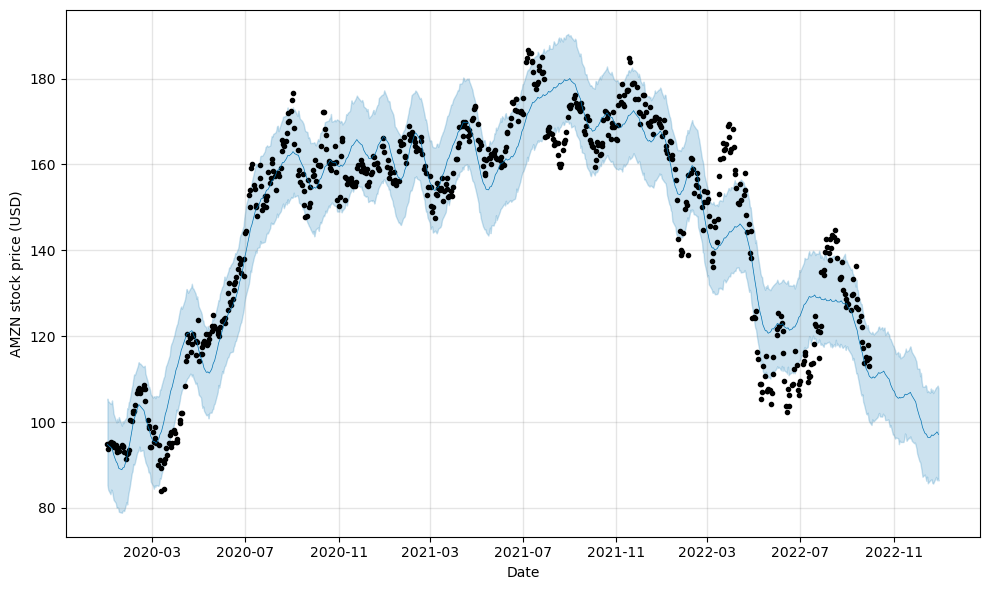

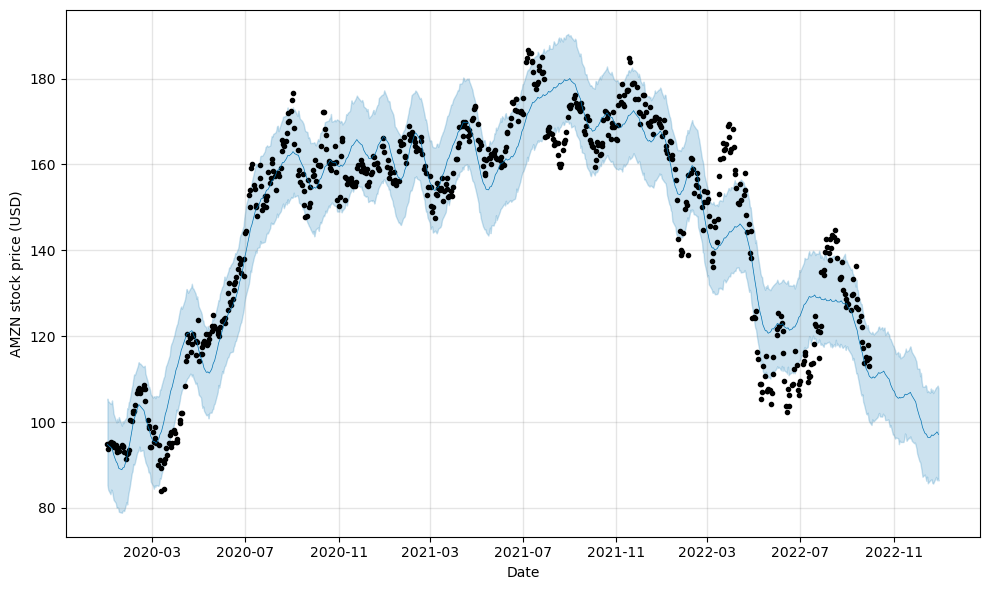

In [32]:
# plot forecast
model.plot(forecast, xlabel='Date', ylabel=stock_code+' stock price (USD)')

## Plot Forecast Components

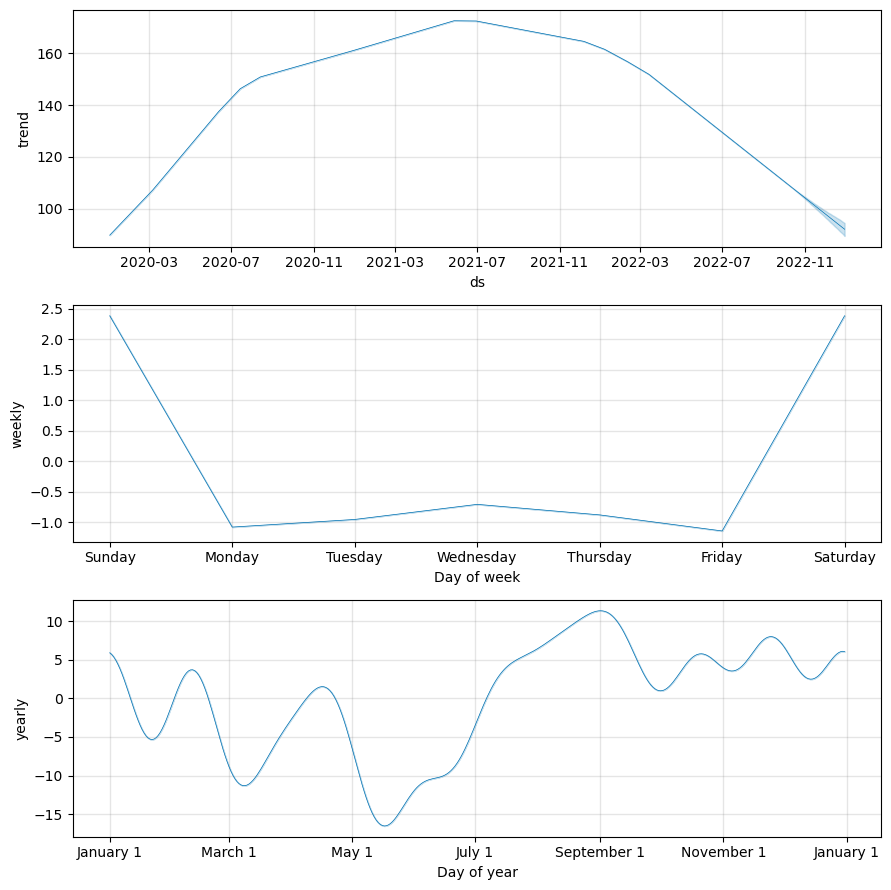

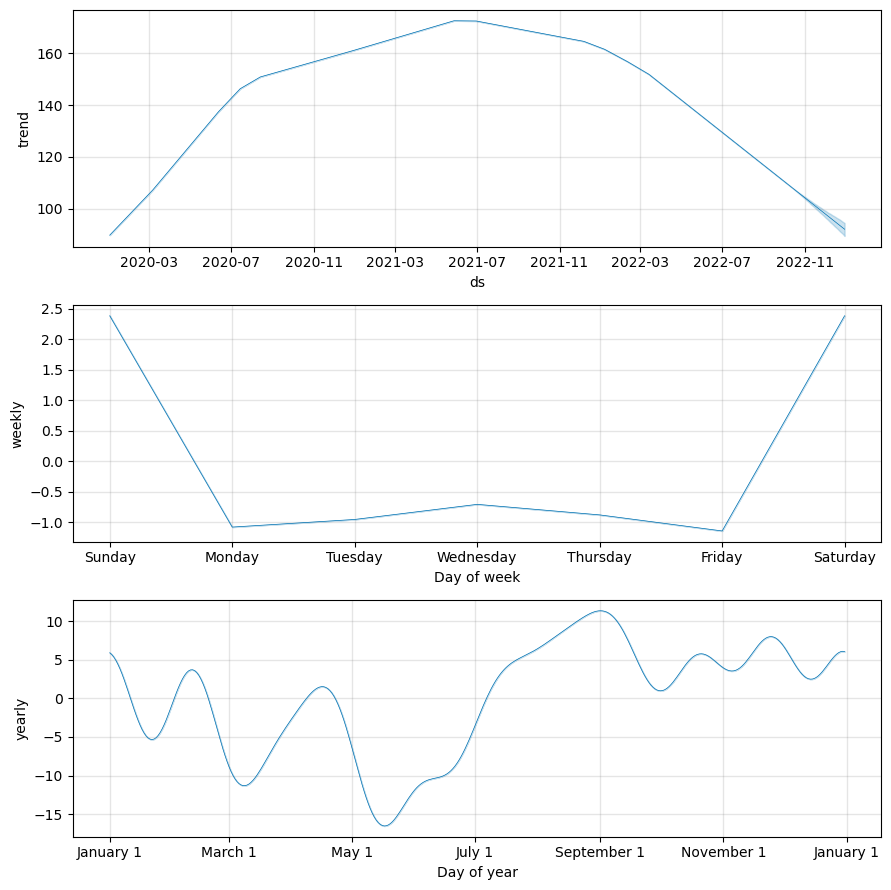

In [33]:
# Plot Forecast Components
model.plot_components(forecast)

# Compare the results


We will not use the prediction from LSTM model because the prediction is several orders of magnitude off any realistic value. Plotting it would mess up the scale of the graph.

In [34]:
# Create summary dataframe with dummy data for prophet, lstm
df_preds_summary = pd.DataFrame(columns=['price','ci_lower','ci_upper'])
df_preds_summary.loc['arima'] = df_preds.iloc[-1]
df_preds_summary.loc['prophet'] = [forecast.iloc[-1,:]['yhat'], forecast.iloc[-1,:]['yhat_lower'], forecast.iloc[-1,:]['yhat_upper']]
#df_preds_summary.loc['lstm'] = [120,70,160]

df_preds_summary

price   ci_lower    ci_upper
arima       133.62  85.655863  208.442292
prophet  97.089492  86.364462  107.841415

In [35]:
def plot_model_comparison(df_train, df_test, df_preds_summary, title=None, log_plot=False):
    """
        df_train, df_test : dataframes with columns date and price holding train and test data
        df_preds : dataframe with columns date, price, ci_upper, ci_lower holding the price
            predictions and upper and lower CIs
        title: string to show as plot title
        log_plot: set to True to make y-axis logarithmic
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_train.date, y=df_train['price'], name="train",
                        line_shape='linear'))
    fig.add_trace(go.Scatter(x=df_test.date, y=df_test['price'], name="test",
                        line_shape='linear'))
    
    # Calculate the range for the horizontal line
    last_30_dates = df_test['date'].tail(30)

    def make_pred_trace(y_line, model, color, mode):
        # Add the horizontal line as a scatter trace to include it in the legend
        
        if mode=='pred':
            showlegend=True
            width=2
            dash=None
        else:
            showlegend=False
            width=1
            dash='dot'
        
        fig.add_trace(go.Scatter(
            #             x=pd.concat([last_30_dates.head(1), last_30_dates.tail(1)]),
            x=pd.concat([last_30_dates.tail(1)+timedelta(days=15),last_30_dates.tail(1)-timedelta(days=15)]),
            y=[y_line, y_line],
            name=model,
            mode='lines',
            line=dict(color=color, width=width, dash=dash),
            showlegend=showlegend
        ))
    
    colors = {'arima':'magenta','prophet':'green','lstm':'black'};
    for model_name, row in df_preds_summary.iterrows():
        make_pred_trace(row['price'], model_name,colors[model_name],'pred')
        make_pred_trace(row['ci_lower'], model_name,colors[model_name],'ci')
        make_pred_trace(row['ci_upper'], model_name,colors[model_name],'ci')        
    
    # Add custom legend entries for pred/ci
    # Invisible entry for separation
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        name='',
        marker=dict(size=1, opacity=0)
    ))
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        name='Prediction',
        line=dict(color='gray', width=2),
    ))

    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='lines',
        name='CI limits',
        line=dict(color='gray', width=1, dash='dot'),
    ))
    
    fig.update_traces(hoverinfo='text+name')
    fig.update_layout(    
                    yaxis_title= stock_code + ' Stock (Adjusted for splits)',
                    title = title,
        autosize=True,
        width=1024,
        height=600)
    fig.update_yaxes(type=("log" if log_plot else "linear"))
    fig.update_xaxes(range=['2022-1-1', '2022-12-31'])

    fig.show()
    
plot_model_comparison(df_train, df_test, df_preds_summary, title=None, log_plot=False)

## Conclusion

Based on the plot above we can see that the actual value of the AMZN stock was USD 84 which was most accurately predicted by the Prophet model (USD 97). The ARIMA model's prediction came in second place at USD 134. 

This is also consistent with the RMSEs obtained: 31.45 for the ARIMA model versus 10.33 for the Prophet model.

Based on these results, the Prophet model seems to be the better choice. The team will continue to repeat the experiments and decide upon a final model to be used for integrating with the user interface.

# Team Contribution

- Costas
  - ARIMA modeling and prediction

- Seth
  - LSTM modeling and prediction

- Shubham
  - Prophet modeling and prediction

- Teamwork
  - Time Series Decomposition
  - Description of Time series
  - Time Series Visualizations
  - Compare and discuss the models
